In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download prithvijaunjale/instagram-images-with-captions

100% 3.84G/3.84G [02:34<00:00, 28.9MB/s]
100% 3.84G/3.84G [02:34<00:00, 26.7MB/s]


In [ ]:
!unzip instagram-images-with-captions.zip -d instagram-images-with-captions

Streaming output truncated to the last 5000 lines.
  inflating: instagram-images-with-captions/instagram_data2/img2/insta29928.jpg  
  inflating: instagram-images-with-captions/instagram_data2/img2/insta29929.jpg  
  inflating: instagram-images-with-captions/instagram_data2/img2/insta29930.jpg  
  inflating: instagram-images-with-captions/instagram_data2/img2/insta29931.jpg  
  inflating: instagram-images-with-captions/instagram_data2/img2/insta29932.jpg  
  inflating: instagram-images-with-captions/instagram_data2/img2/insta29933.jpg  
  inflating: instagram-images-with-captions/instagram_data2/img2/insta29934.jpg  
  inflating: instagram-images-with-captions/instagram_data2/img2/insta29935.jpg  
  inflating: instagram-images-with-captions/instagram_data2/img2/insta29936.jpg  
  inflating: instagram-images-with-captions/instagram_data2/img2/insta29937.jpg  
  inflating: instagram-images-with-captions/instagram_data2/img2/insta29938.jpg  
  inflating: instagram-images-with-captions/ins

In [ ]:
!rm -r ./instagram-images-with-captions.zip

NotImplementedError: ignored

In [ ]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import json
from datasets import load_dataset

In [ ]:
!ls ./instagram-images-with-captions/instagram_data

captions_csv.csv  img


In [ ]:
ROOT_DIR = './instagram-images-with-captions/instagram_data/img/'
captions_df = pd.read_csv('./instagram-images-with-captions/instagram_data/captions_csv.csv')
captions_df.head(5)

,Sr No,Image File,Caption
0,1,img/insta1,NaN
1,2,img/insta2,bye
2,3,img/insta3,"Ok, a few more... sorry I just had so much fun..."
3,4,img/insta4,This was one of my favorite shoots I’ve ever d...
4,5,img/insta5,Wrapped round my finger like a ring


In [ ]:
# Convert the captions_df to a list of dictionaries similar to captions_format
captions = []
for _, row in captions_df.iterrows():
  file_name = row["Image File"].split("/")[1] + ".jpg"
  text = row["Caption"] if not pd.isnull(row["Caption"]) else ""
  captions.append({"file_name": file_name, "text": text})

captions[:5]

[{'file_name': 'insta1.jpg', 'text': ''},
 {'file_name': 'insta2.jpg', 'text': 'bye '},
 {'file_name': 'insta3.jpg',
  'text': 'Ok, a few more... sorry I just had so much fun that day '},
 {'file_name': 'insta4.jpg',
  'text': 'This was one of my favorite shoots I’ve ever done! Thank you -a seriously badass woman, for shooting my cover! And thank you to everyone who asked a question for the interview 🤍 '},
 {'file_name': 'insta5.jpg', 'text': 'Wrapped round my finger like a ring '}]

In [ ]:
root = ROOT_DIR
# Write captions to a jsonl file
with open(f'{root}metadata.jsonl', 'w') as f:
  for item in captions:
    f.write("%s\n" % json.dumps(item))

In [ ]:
# Load the dataset
dataset = load_dataset('imagefolder', data_dir=root, split='train')

Resolving data files:   0%|          | 0/20516 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-b5697e8d663efb8c/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 20515
})

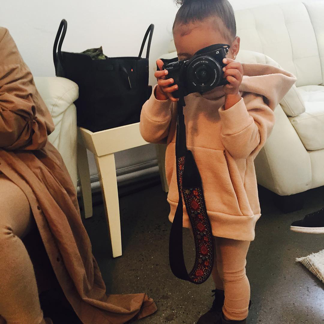

In [ ]:
example = dataset[101]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [ ]:
example["text"]

'📷 our own personal backstage photog '

In [ ]:
# Filter out the images with captions that are at least 5 words long
dataset = dataset.filter(lambda x: len(x["text"].split()) >= 5)

# Take 1000 images at random from the dataset to create a validation set
dataset = dataset.shuffle(seed=42)
dataset = dataset.select(range(1000))

Filter:   0%|          | 0/20515 [00:00<?, ? examples/s]

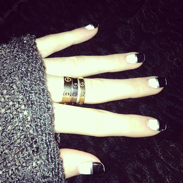

In [ ]:
example = dataset[101]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [ ]:
example["text"]

'Slacking on my nail game. '

In [ ]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]

    encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

    # remove batch dimension
    encoding = {k:v.squeeze() for k,v in encoding.items()}

    return encoding

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)

In [ ]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
pixel_values torch.Size([4, 3, 224, 224])


In [ ]:
processor.decode(batch["input_ids"][0])

'[CLS] yes i\'m the dumb american who wears a " france " shirt in france [UNK] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

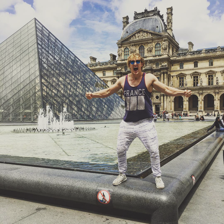

In [ ]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

In [ ]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(12.0451, grad_fn=<NllLossBackward0>)

In [ ]:
print(f"{1000 / 4} steps to be taking in one epoch")

250.0 steps to be taking in one epoch


In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(25):
  print("Epoch:", epoch)
  counter = 0
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    # print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    
    counter += 1
    if counter % 50 == 0:
      print("Loss:", loss.item()) 
      print(f"{counter} steps done")

Epoch: 0
Loss: 0.1011122465133667
50 steps done
Loss: 0.0831543356180191
100 steps done
Loss: 0.24462710320949554
150 steps done
Loss: 0.19890613853931427
200 steps done
Loss: 0.090815469622612
250 steps done
Epoch: 1
Loss: 0.1417655050754547
50 steps done
Loss: 0.15924619138240814
100 steps done
Loss: 0.06798398494720459
150 steps done
Loss: 0.07626299560070038
200 steps done
Loss: 0.08373720943927765
250 steps done
Epoch: 2
Loss: 0.0849730521440506
50 steps done
Loss: 0.0816093161702156
100 steps done
Loss: 0.22571364045143127
150 steps done
Loss: 0.11420412361621857
200 steps done
Loss: 0.11313165724277496
250 steps done
Epoch: 3
Loss: 0.04265696927905083
50 steps done
Loss: 0.10234742611646652
100 steps done
Loss: 0.0547252893447876
150 steps done
Loss: 0.06090683490037918
200 steps done
Loss: 0.07348529994487762
250 steps done
Epoch: 4
Loss: 0.026595577597618103
50 steps done
Loss: 0.06580718606710434
100 steps done
Loss: 0.03536318615078926
150 steps done
Loss: 0.0623056292533874

### Inferencing

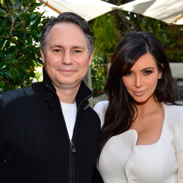

In [ ]:
# load image
example = dataset[5]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=300)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

i'm gonna open one in la and atl


In [ ]:
example["text"]

"Me & at the DuJour lunch 2 weeks ago! Can't wait for our NY event! Follow him, he's kinda funny! 😜 "